In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

### Read data

In [31]:
# Read data
uncertainty = pd.read_csv('../data/processed/uncertainty_index.csv')
ip = pd.read_csv('../data/processed/ip.csv', encoding='unicode_escape')

# Merge
data = pd.merge(uncertainty,ip,on='Period')

# Set 'period' as the index
data.set_index('Period', inplace=True)

# Create a new column 'y_diff' representing the difference (lagged by 1 period) of ip
data['IP_diff'] = data['IP'].diff()
data.dropna(inplace=True)


In [32]:
ip

,Period,IP
0,2010-01-01,48.9603
1,2010-02-01,50.7856
2,2010-03-01,52.2230
3,2010-04-01,53.0761
4,2010-05-01,53.6887
...,...,...
169,2024-02-01,147.6236
170,2024-03-01,148.5688
171,2024-04-01,149.9856
172,2024-05-01,153.0475


In [33]:
data.head()

,uncertainty,IP,IP_diff
Period,,,
2010-08-01,0.692503,55.3840,0.7014
2010-09-01,0.060590,55.8684,0.4844
2010-10-01,0.571026,56.3300,0.4616
2010-11-01,0.038444,57.5808,1.2508
2010-12-01,0.007449,59.3844,1.8036


### STNSU & IP

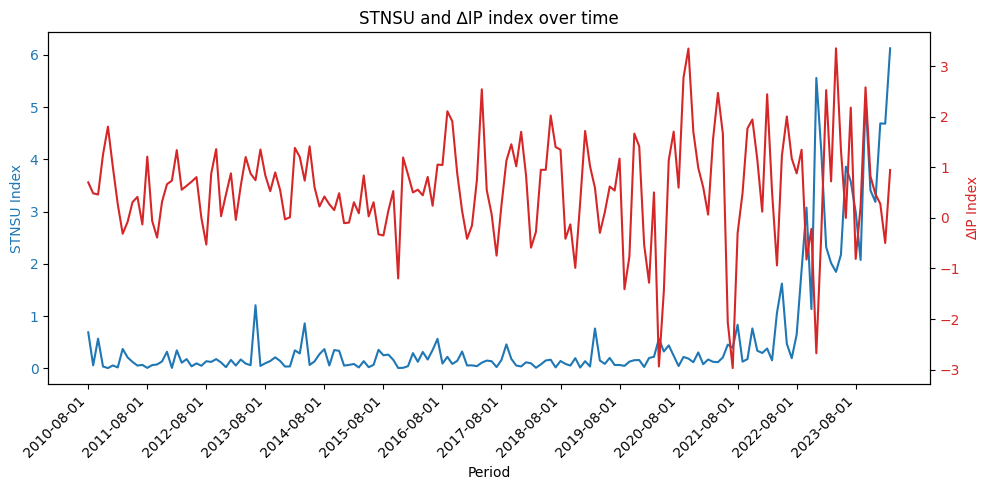

In [34]:

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the first time series on the left y-axis (ax1)
color = 'tab:blue'
ax1.set_xlabel('Period')
ax1.set_ylabel('STNSU Index', color=color)
ax1.plot(data.index, data['uncertainty'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis (ax2) on the right
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('∆IP Index', color=color)
ax2.plot(data.index, data['IP_diff'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set x-axis ticks at intervals of 12 periods and rotate x-labels
ax1.set_xticks(data.index[::12])
ax1.set_xticklabels(data.index[::12], rotation=45, ha='right')

# Show the plot
plt.title('STNSU and ∆IP index over time')
plt.tight_layout() 
plt.show()


### Model


In [35]:
# Set target and feature data
Y = data['IP_diff']
X = data['uncertainty']


In [36]:
def lag_list(Y, X, p=1, q=0):

    ADLx = pd.DataFrame()
    T = len(Y)
    ADLy = list(Y[max(p, q):T])
    for i in range(1, p+1):
        name = f'y_{i}'
        ADLx[name] = list(Y[max(p, q)-i:T-i])
    for i in range(1, q+1):
        name = f'x_{i}'
        ADLx[name] = list(X[max(p, q)-i:T-i])
        
    return ADLy, ADLx
    

In [37]:

# Define a function to fit the ADL model and calculate AIC
def fit_adl_model(Y, X, p, q):
    ADLy, ADLx = lag_list(Y, X, p, q)
    ADLx = sm.add_constant(ADLx)
    model = sm.OLS(ADLy, ADLx)
    results = model.fit()
    return results, results.aic

# Grid search for lag orders
best_aic = float('inf')
best_p, best_q = 0, 0

for p in range(1, 10 + 1):
    for q in range(0, 10 + 1):
        _, aic = fit_adl_model(Y, X, p, q)
        if aic < best_aic:
            best_aic = aic
            best_p, best_q = p, q

print("Best AIC:", best_aic)
print("Best p, q:", best_p, best_q)


Best AIC: 425.8249410888711
Best p, q: 4 9


In [41]:
# Model 1
ADLy1, ADLx1 = lag_list(Y, X, p=1, q=1)
ADLx1 = sm.add_constant(ADLx1)
mod1 = sm.OLS(ADLy1, ADLx1)
res1 = mod1.fit()

print("Summary for Model:")
print(res1.summary())

Summary for Model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     9.518
Date:                Tue, 30 Jul 2024   Prob (F-statistic):           0.000124
Time:                        12:32:10   Log-Likelihood:                -225.06
No. Observations:                 163   AIC:                             456.1
Df Residuals:                     160   BIC:                             465.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3604      0.097 

In [42]:
# Model 2
ADLy2, ADLx2 = lag_list(Y, X, p=1, q=0)
ADLx2 = sm.add_constant(ADLx2)
mod2 = sm.OLS(ADLy2, ADLx2)
res2 = mod2.fit()

print("Summary for Model:")
print(res2.summary())

Summary for Model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     18.68
Date:                Tue, 30 Jul 2024   Prob (F-statistic):           2.70e-05
Time:                        12:32:15   Log-Likelihood:                -225.28
No. Observations:                 163   AIC:                             454.6
Df Residuals:                     161   BIC:                             460.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3878      0.087 

In [43]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have test data and true values 'y_true'

# Get model predictions on the test data
y_pred_model1 = res1.predict(ADLx1)
y_pred_model2 = res2.predict(ADLx2)

# # Assuming 'period' is the name of the index in Y and y_pred_model1
# Set the index of y_pred_model1 to match the index of Y
y_pred_model1.index = Y.index[1:]  # Exclude the first element due to lag
error_model1 = Y[1:] - y_pred_model1  # Exclude the first element due to lag

y_pred_model2.index = Y.index[1:]
error_model2 = Y[1:] - y_pred_model2


# Calculate squared differences between forecast errors
squared_diff = (error_model1 - error_model2)**2

# Calculate mean squared differences
mean_squared_diff = np.mean(squared_diff)

# Calculate standard error of the mean squared differences
n = len(Y)
se_squared_diff = np.sqrt((1/n) * mean_squared_diff)

# Calculate standard errors for DM statistic
variance_dm = (2 * (mean_squared_diff**2)) / (n - 1)
se_dm_statistic = np.sqrt(variance_dm)

# Calculate DM statistic
dm_statistic = mean_squared_diff / se_squared_diff

# Print DM statistic and its standard error
print("DM Statistic (Model 1 vs Model 2):", dm_statistic)
print("Standard Error of DM Statistic:", se_dm_statistic)


DM Statistic (Model 1 vs Model 2): 0.6335866795658481
Standard Error of DM Statistic: 0.00027113739791840614
